In [1]:
import numpy as np
import chaospy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

# kucherenko_quantile function

In [11]:
def kucherenko_quantile(alp,N,miu,sd):
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp)
    Q1_alp, Q2_alp = _nomalized_quantile_based_measures(N,M,dim,alp)
    
    return q1_alp, q2_alp, Q1_alp, Q2_alp


def _quantile_based_measures(N,M,dim,alp):
    # shape(1, 4, 1, 64)
    delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    q1_alp=np.zeros((len(alp),dim))
    q2_alp=np.zeros((len(alp),dim))
    
    qy_alp1 = _unconditional_q_Y(N,M,dim)
    qy_alp2 = _conditional_q_Y(N,M,dim,alp)
    
    for i in range(dim):
        for pp in range(len(alp)):
            delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
            q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
            q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2
            
    return q1_alp, q2_alp


def _nomalized_quantile_based_measures(N,M,dim,alp):
    # shape(1, 31)
    q1=np.zeros(len(alp))
    q2=np.zeros(len(alp))

    Q1_alp=np.zeros((len(alp),dim))
    Q2_alp=np.zeros((len(alp),dim))
    
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp)
    
    for pp in range(len(alp)):
        q1[pp]=np.sum(q1_alp[pp,:])
        q2[pp]=np.sum(q2_alp[pp,:])
        for i in range(dim):
            Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
            Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]
    
    return Q1_alp, Q2_alp


def _unconditional_q_Y(N,M,dim):
    A,B  = _get_samples(N, M, dim)
    # values of outputs
    Y1 = objfun(A)
    # reorder in ascending order
    y1 = np.sort(Y1)
    
    # q_Y(alp)
    q_index = (np.floor(alp*N)-1).astype(int)
    qy_alp1 = y1[q_index]
    
    return qy_alp1 


def _conditional_q_Y(N,M,dim,alp):
    A,B  = _get_samples(N, M, dim)
    
    # conditional sample matrix C,with shape(64, 4, 8192, 4)
    C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

    for i in range(dim):
        for j in range(M):
            C[j,i] = A
            C[j,i,:,i] = B[j, i]  
    # values of conditional outputs
    # shape(8192, 4, 8192, 1)
    Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    
    # shape(1, 4, 31, 64)
    qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    
    for i in range(dim):
        for j in range(M):
            Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
            Y2[j,i].sort(axis=0)
            y2[j,i] = Y2[j,i] # reorder in ascending order
            for pp in range(len(alp)):
                qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)
    
    return qy_alp2


def _get_samples(N, M, dim):
    
    A = np.zeros((N,dim))
    B = np.zeros((M,dim))
    X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
    X02 = cp.generate_samples(order=M, domain=dim, rule="S").T
    
    A = norm.ppf(X01,loc=miu, scale=sd)
    B = norm.ppf(X02,loc=miu, scale=sd)

    return A,B

# parameters

In [12]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

# dimension of inputs
dim = np.size(miu) # 4

# Test 1: Linear function

In [13]:
# mean for normal distribution
miu = np.array([1,3,5,7])

# standard deviation for normal distribution
sd = np.array([1,1.5,2,2.5])

a = [1,1,1,1]

def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result

In [14]:
q1_alp, q2_alp, Q1_alp, Q2_alp=kucherenko_quantile(alp,N,miu,sd)

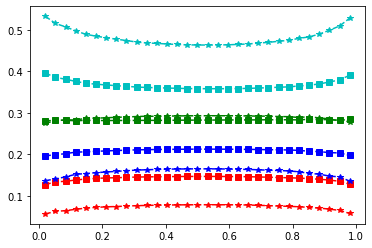

In [10]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')